In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

# matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

In [2]:
df = pd.read_csv('df_features.csv')
print(df.shape)
df.head()

(40540, 98)


,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_3_std,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std
0,38359_Rock_music.wav,0.291,0.350,0.553,-0.679,0.261,0.050,0.349,0.030,107.666,...,0.280,0.229,0.221,0.316,0.195,0.256,0.248,0.268,0.256,0.251
1,50194_Rock_music.wav,0.222,0.278,0.990,-0.015,0.134,0.027,0.276,0.030,135.999,...,0.252,0.294,0.337,0.289,0.281,0.217,0.257,0.216,0.286,0.285
2,24275_Hip_hop_music.wav,0.174,0.232,1.326,0.876,0.253,0.061,0.223,0.065,143.555,...,0.333,0.333,0.229,0.153,0.155,0.252,0.273,0.283,0.306,0.303
3,43654_Pop_music.wav,0.306,0.373,0.607,-0.578,0.084,0.043,0.370,0.051,123.047,...,0.209,0.216,0.260,0.322,0.299,0.264,0.193,0.306,0.272,0.234
4,41609_Rock_music.wav,0.237,0.298,1.004,0.021,0.165,0.062,0.294,0.047,123.047,...,0.255,0.186,0.274,0.241,0.222,0.181,0.246,0.315,0.170,0.276


In [3]:
label_dict = {'Hip':0,
              'Pop':1,
              'Vocal':2,
              'Rhythm':3,
              'Reggae':4,
              'Rock':5,
              'Techno':6,
             }

# Normalization of the features
scalar = MinMaxScaler()
df[df.columns[1:]] = scalar.fit_transform(df[df.columns[1:]])
df['label'] = df['file_name'].apply(lambda x: label_dict[x[:-4].split('_')[1]])
df.head()

,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std,label
0,38359_Rock_music.wav,0.313240,0.370763,0.140444,0.002384,0.426471,0.190840,0.370488,0.089820,0.322914,...,0.477083,0.463312,0.691466,0.407098,0.535565,0.513458,0.557173,0.556522,0.548035,5
1,50194_Rock_music.wav,0.238967,0.294492,0.155385,0.003066,0.218954,0.103053,0.292994,0.089820,0.473681,...,0.612500,0.706499,0.632385,0.586639,0.453975,0.532091,0.449064,0.621739,0.622271,5
2,24275_Hip_hop_music.wav,0.187298,0.245763,0.166872,0.003982,0.413399,0.232824,0.236730,0.194611,0.513888,...,0.693750,0.480084,0.334792,0.323591,0.527197,0.565217,0.588358,0.665217,0.661572,0
3,43654_Pop_music.wav,0.329386,0.395127,0.142291,0.002488,0.137255,0.164122,0.392781,0.152695,0.404760,...,0.450000,0.545073,0.704595,0.624217,0.552301,0.399586,0.636175,0.591304,0.510917,1
4,41609_Rock_music.wav,0.255113,0.315678,0.155863,0.003103,0.269608,0.236641,0.312102,0.140719,0.404760,...,0.387500,0.574423,0.527352,0.463466,0.378661,0.509317,0.654886,0.369565,0.602620,5


In [4]:
# Train-test split of files # Same split as used for VGG model
with open('pred_probas/testset_filenames.txt', 'r') as f:
    test_files = f.readlines()
test_files = [t.strip() for t in test_files]

indices = []
for t in test_files:
    indices.append(df[df.file_name==t].index[0])
    
df_test = df.iloc[indices,:]
df.drop(labels=indices, inplace=True)

cl_weight = dict(pd.Series(df['label']).value_counts(normalize=True))

x_train = df[df.columns[1:-1]]
x_test = df_test[df.columns[1:-1]]
y_train = df['label']
y_test = df_test['label']

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(label_dict))
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=label_dict.keys())

### Logistic Regression
LR is usually done for binary classification tasks. For this multi-class classification task, the LR is implemented as a one-vs-rest method. That is, 7 separate classifiers are trained. During test time, the class with the highest prob. from among the 7 classifiers is the predicted class.

Test Set Accuracy =  0.53
Test Set F-score =  0.47
ROC AUC = 0.822
Confusion matrix, without normalization
[[236  49   5   7  10  21  36]
 [ 58 193  18   9   1  69  35]
 [ 15  21  90   5   2  27  11]
 [ 54  70   9  24  11  32  32]
 [ 43  42   6   1  27   8   5]
 [ 10  42  14   2   1 324  23]
 [ 27  41  10   5   3  55 188]]
CPU times: user 16.7 s, sys: 96.2 ms, total: 16.8 s
Wall time: 15.9 s


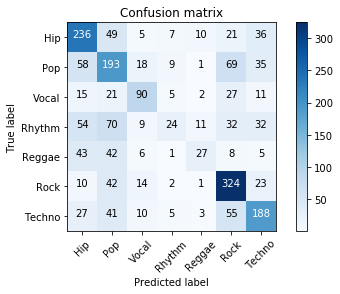

In [6]:
%%time
# Train
lr_classifier = LogisticRegression(penalty='l2')
lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Random Forest

Test Set Accuracy =  0.54
Test Set F-score =  0.48
ROC AUC = 0.840
Confusion matrix, without normalization
[[248  50  15   6   9  12  24]
 [ 59 200  21   6   3  69  25]
 [ 14  23  96   5   0  23  10]
 [ 58  74   8  23   7  35  27]
 [ 43  40   6   6  25  10   2]
 [ 11  50  12   0   0 322  21]
 [ 26  36  16   3   2  59 187]]
CPU times: user 2min 55s, sys: 284 ms, total: 2min 55s
Wall time: 2min 55s


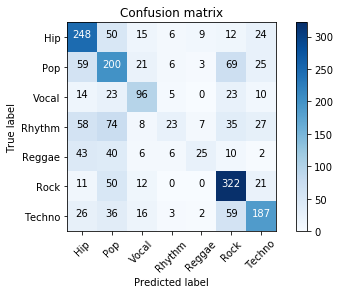

In [7]:
%%time
# Train
rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=5)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Gradient Boosting 

Test Set Accuracy =  0.59
Test Set F-score =  0.55
ROC AUC = 0.865
Confusion matrix, without normalization
[[238  51  10  13  13  14  25]
 [ 47 214  18  18   7  55  24]
 [  9  16 107   5   3  18  13]
 [ 48  66   7  42  12  29  28]
 [ 29  28   6  11  45   6   7]
 [  9  48   9   5   1 328  16]
 [ 23  29   8   7   5  40 217]]
CPU times: user 18min 30s, sys: 39.8 ms, total: 18min 30s
Wall time: 18min 30s


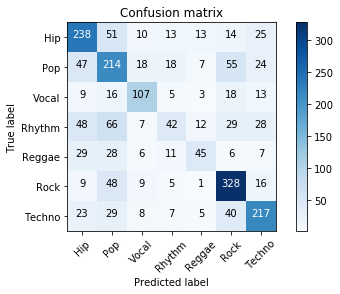

In [10]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Support Vector Machines

Test Set Accuracy =  0.57
Test Set F-score =  0.52
ROC AUC = 0.856
Confusion matrix, without normalization
[[237  57   5   9  13  18  25]
 [ 47 222  15   8   4  60  27]
 [ 17  18 102   2   1  22   9]
 [ 47  85   7  22  14  30  27]
 [ 27  41   4   3  44   7   6]
 [  9  50  13   2   1 325  16]
 [ 31  33   7   2   4  45 207]]
CPU times: user 1h 7s, sys: 6.75 s, total: 1h 14s
Wall time: 1h 14s


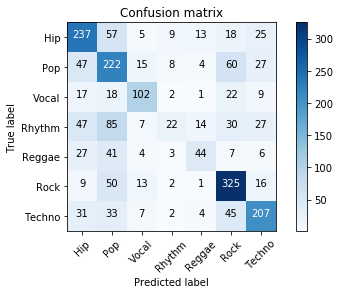

In [9]:
%%time
# Train
svm_classifier = SVC(C=10000.0, probability = True, class_weight=cl_weight, kernel='rbf')
svm_classifier.fit(x_train, y_train)

# Predict
pred_probs = svm_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/svm_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Most Important Feature
Determine the features that contribute the most towards making the correct classfication

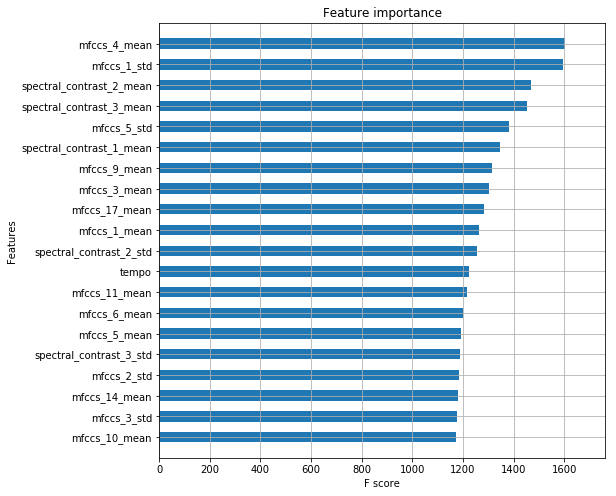

In [11]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=20, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)
# plt.savefig('plots/feature-imp.png', bbox_inches='tight')

The most important features seem to be MFCCs and spectral contrast (mean and std dev in different frequency bins). Use the top N features, build the model and look at the metrics

In [8]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([ 0.00601963,  0.00661311,  0.01037538,  0.01055554,  0.00904004,
        0.0082028 ,  0.00390004,  0.01185909,  0.01299307,  0.00674029,
        0.00929439,  0.00670849,  0.00784247,  0.00949575,  0.01069332,
        0.        ,  0.        ,  0.01427542,  0.01558956,  0.0153988 ,
        0.01170012,  0.01088408,  0.01113843,  0.01191208,  0.012336  ,
        0.01330041,  0.01260095,  0.01007864,  0.01046016,  0.0112762 ,
        0.01241018,  0.00739736,  0.00848895,  0.01337459,  0.00896585,
        0.01379851,  0.01698849,  0.01265393,  0.01271752,  0.01198626,
        0.01172132,  0.01392569,  0.01244198,  0.01289769,  0.01215583,
        0.01224062,  0.01251616,  0.01188029,  0.01183789,  0.01358655,
        0.01112783,  0.01087348,  0.0123042 ,  0.0169143 ,  0.01254796,
        0.01246317,  0.01225121,  0.01466754,  0.01104305,  0.01161534,
        0.01035418,  0.00895526,  0.01023761,  0.01000445,  0.00884928,
        0.0082346 ,  0.00860552,  0.00905064,  0.00802264,  0.00

In [9]:
top_n = [10, 20, 30]
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                       n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm = False)     
    print()

Stats for top 10 features:
Test Set Accuracy =  0.47
Test Set F-score =  0.42
ROC AUC = 0.803

Stats for top 20 features:
Test Set Accuracy =  0.52
Test Set F-score =  0.48
ROC AUC = 0.837

Stats for top 30 features:
Test Set Accuracy =  0.55
Test Set F-score =  0.51
ROC AUC = 0.845



### Ensemble of XGB and VGG

Test Set Accuracy =  0.65
Test Set F-score =  0.62
ROC AUC = 0.894
Confusion matrix, without normalization
[[250  48   4  19  14   8  19]
 [ 33 233  14  22   6  45  28]
 [  9  18 116   1   2  15   8]
 [ 45  59   2  66   8  33  19]
 [ 26  22   5   4  62   9   4]
 [ 10  35   8   5   1 344  10]
 [ 10  24  10   8   5  30 240]]


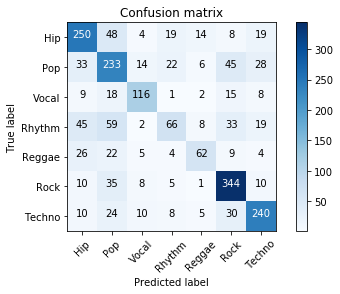

In [7]:
# Load predicted probabilities
with open('pred_probas/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/vgg_fine_tuning.pkl', 'rb') as f:
    vgg_pred_probs = pickle.load(f)
    
n_samples = np.min([len(xgb_pred_probs), len(vgg_pred_probs)])

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs[:n_samples] + vgg_pred_probs[:n_samples])/2.0

# Show metrics
display_results(y_test[:n_samples], ensemble_pred_probs)

### Plot 3 ROCs the same graph
- VGG
- XGB
- Ensemble

In [8]:
# Compute macro-average ROC curve and ROC area
# Compute ROC curve and ROC area for each class

def plot_roc_curves(y_true, pred_probs, label_dict):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    NUM_CLASSES = len(label_dict)
    one_hot_true = one_hot_encoder(y_true, len(y_true), NUM_CLASSES)
    for i in range(len(label_dict)):
        fpr[i], tpr[i], _ = roc_curve(one_hot_true[:, i], pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])    

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= NUM_CLASSES

    return all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

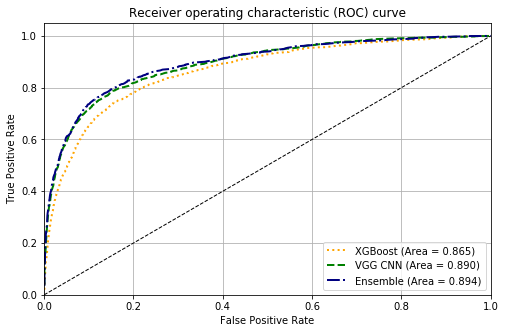

In [9]:
# Plot all ROC curves
plt.figure(figsize=(8,5))

plt.title('Macro-average ROC curves')

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], xgb_pred_probs[:n_samples], label_dict)
plt.plot(fpr, tpr,
         label='XGBoost (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='orange', linestyle=':', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], vgg_pred_probs[:n_samples], label_dict)
plt.plot(fpr, tpr,
         label='VGG CNN (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='green', linestyle='--', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], ensemble_pred_probs[:n_samples]
                                    , label_dict)
plt.plot(fpr, tpr,
         label='Ensemble (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='navy', linestyle='-.', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
# plt.savefig('plots/roc-curve.png')
plt.show()

#### Time Domain Feature Only

Test Set Accuracy =  0.40
Test Set F-score =  0.34
ROC AUC = 0.731
Confusion matrix, without normalization
[[183  60   8  16  10  34  53]
 [ 59 143  17  12   8 106  38]
 [ 24  32  56   4   2  33  20]
 [ 78  47  12  10  13  41  31]
 [ 40  35   5   5  20  13  14]
 [ 27  70  10   7   7 252  43]
 [ 48  53  12   9   8  62 137]]
CPU times: user 1min 23s, sys: 16.1 ms, total: 1min 23s
Wall time: 1min 23s


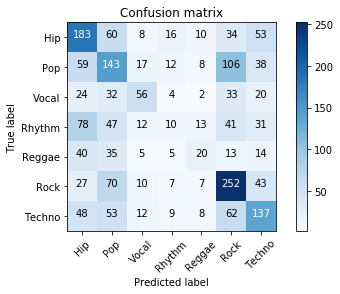

In [14]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train.iloc[:,:9], y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test.iloc[:,:9])

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier_time_domain.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

#### Frequency Domain Feature Only

Test Set Accuracy =  0.57
Test Set F-score =  0.53
ROC AUC = 0.857
Confusion matrix, without normalization
[[230  55  10  14  16  14  25]
 [ 55 203  18  19   6  52  30]
 [ 12  11 106   6   4  18  14]
 [ 44  62   5  46  19  31  25]
 [ 25  32   5  14  43   8   5]
 [ 13  50   8   5   1 317  22]
 [ 23  31  11   7   3  51 203]]
CPU times: user 17min 8s, sys: 28 ms, total: 17min 8s
Wall time: 17min 8s


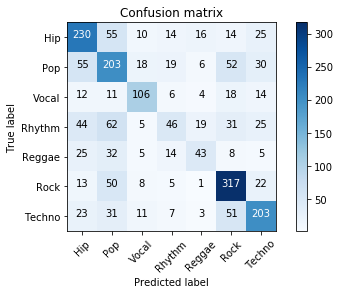

In [15]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train.iloc[:,9:], y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test.iloc[:,9:])

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier_freq_domain.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)